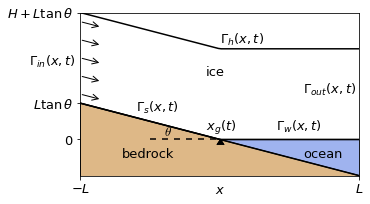

In [1]:
#======================= import essential libraries===========================
import numpy as np
import vtk as vtk
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def bedrock(x):
    return (200-0.02*x)
def b(x):
    return 0.5*(np.abs(200-0.02*x)+(200-0.02*x))

#======================= input parameters ===========================
Hght = 500                   # Height(m)
Lngth = 2e4                  # Lngth(m)               
tol = 1e-3                   # Tolerance(m)
T = 0.5*3.154e7/(12.0*30.0)  # solar tide period
sea_level = Hght*0.917       # sea level(m)
r_lake = 0.5e3               # range of lake (m)

# plot settings
fs = 15                      # FontSize
marker = 6                   # MarkerType

X = np.linspace(0,Lngth,100) # x-grid
top_bound=b(X)+Hght           # top bound

#=========================== Figure 1 ==============================
fig,ax = plt.subplots(figsize=(5,3), constrained_layout=False)
plt.rcParams["figure.dpi"] = 300
plt.style.use('classic')
#---------------------------- color --------------------------------
plt.fill_between(X,bedrock(X),b(X),facecolor='royalblue',alpha=0.5)
plt.fill_between(X,-1000*np.ones(np.size(X)),bedrock(X),facecolor='burlywood',alpha=1.0)
plt.plot(X,bedrock(X),color='k',linewidth=1.5,label=r'$\beta$') # bedrock
plt.plot(X,b(X),color='k',linewidth=1.5,label=r'$s>\beta$') # ice-water interface
plt.plot(X,top_bound,color='k',linewidth=1.5,label=r'$h$') # surface

#-------------------------- grounding line -------------------------
line1 = ax.scatter(1e4, b(1e4), marker=marker, c='k', s=50)
ax.scatter(1e4, b(1e4), marker=marker, c='k', s=50)

# inflow
for ih,hh in enumerate([0.1,0.3,0.5,0.7,0.9]):
    arr1 = patches.FancyArrowPatch((0,200+hh*Hght),(1.5e3,200+hh*Hght-1.5e3*0.02), arrowstyle='->', mutation_scale=15)
    ax.add_patch(arr1)

#-------------------------- annotation -------------------------
top = plt.annotate(r"$\Gamma_h\left(x,t\right)$",xy=(10.0e3,530),fontsize=fs-2, math_fontfamily='dejavusans')
ice_bed = plt.annotate(r"$\Gamma_s\left(x,t\right)$",xy=(4.0e3,b(5.0e3)+50),fontsize=fs-2, math_fontfamily='dejavusans')
ice_water = plt.annotate(r"$\Gamma_w\left(x,t\right)$",xy=(14.0e3,50),fontsize=fs-2, math_fontfamily='dejavusans')
outflow = plt.annotate(r"$\Gamma_{out}\left(x,t\right)$",xy=(16.0e3,250),fontsize=fs-2, math_fontfamily='dejavusans')
inflow = plt.annotate(r"$\Gamma_{in}\left(x,t\right)$",xy=(-3.0e3,350),fontsize=fs-2, math_fontfamily='dejavusans')
gl = plt.annotate(r"$x_g\left(t\right)$",xy=(9.0e3,50),fontsize=fs-2, math_fontfamily='dejavusans')

plt.annotate(r"bedrock",xy=(3.0e3,-100),fontsize=fs-2)
plt.annotate(r"ocean",xy=(16.0e3,-100),fontsize=fs-2)
plt.annotate(r"ice",xy=(9.0e3,350),fontsize=fs-2)

ax.plot([5e3,10e3],[0,0],linestyle='--',color='k',linewidth=1.5)
plt.annotate(r"$\theta$",xy=(6e3,20),fontsize=fs-2)

#---------------------------- y axis --------------------------------
plt.yticks([0,200,700],[r'$0$',r'$L\tan\theta$',r'$H+L\tan\theta$'],\
                   fontsize=fs-2, math_fontfamily='dejavusans')
plt.ylabel(r"$\Gamma_{in}\left(x,t\right)$",fontsize=fs-2, rotation=0, math_fontfamily='dejavusans')
ax.yaxis.set_label_coords(-0.10, 0.65)
#---------------------------- x axis --------------------------------
plt.xlabel(r'$x$',fontsize=fs-2, math_fontfamily='dejavusans')
plt.xticks(2*np.array([0.0e3,10e3]),\
           [r'$-L$',r'$L$'],\
           fontsize=fs-2, math_fontfamily='dejavusans')
ax.xaxis.set_label_coords(0.5, -0.05)

plt.ylim(-200,700.0,8)
plt.xlim(0.0*Lngth,Lngth)

plt.savefig('../figures/figure_1.pdf',bbox_inches='tight',dpi=300)
# plt.savefig('../figures/figure_1(high-resolution).tiff',bbox_inches='tight',dpi=600)